**Telecom Customer Retention Project  
Will Byrd, May 2024  
Intrduction**

In this notebook, I will create classification models to predict wether or not a customer kept their subscription to the phone service.  

**Data**

The data used in this project is from Kaggle's Churn in Telecom's Dataset.  This data is remarkably clean with no missing values and will allow me to focus on the principles of model building.  Each record in this dataset represents a customer in Telecom and has attributes such as state, length of subscription, type of plan, usage, and wether or not the churned.  a customer who has churned has cancelled their subscription, so in this case, we will be targeting customers who have not churned or have a value of false in the churn column.  The churn column is our target column.

**Goals**

Build various models to evaluate the data.


**Explaratory Data Analysis**  

Loading in tools for data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from seaborn import load_dataset
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV

Loading in the dataset.  Here, I will call it 'customer_df'

In [2]:
customer_df = pd.read_csv ('Data/telecom.csv')

In [3]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [4]:
customer_df.drop(columns=['phone number'], inplace=True)

In [5]:
customer_df['churn'] = customer_df['churn'].astype(float)

In [6]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   international plan      3333 non-null   object 
 4   voice mail plan         3333 non-null   object 
 5   number vmail messages   3333 non-null   int64  
 6   total day minutes       3333 non-null   float64
 7   total day calls         3333 non-null   int64  
 8   total day charge        3333 non-null   float64
 9   total eve minutes       3333 non-null   float64
 10  total eve calls         3333 non-null   int64  
 11  total eve charge        3333 non-null   float64
 12  total night minutes     3333 non-null   float64
 13  total night calls       3333 non-null   int64  
 14  total night charge      3333 non-null   

How lucky!  We don't have to impute data! We have a clean dataset!  This will make our process much easier going forward.  Now to figure out what all of these columns contain.

In [7]:
customer_df.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0.0
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0.0
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0.0
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0.0
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0.0


In [8]:
customer_df.isna().sum()

state                     0
account length            0
area code                 0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

Looks like we have columns of data for various phone accounts.  We can see the state in which the person lives, the phone number, area code, and details of their plan.

Now we need to figure out consistent themes/patterns in accounts that churned versus accounts that renewed.

First thing I'm interested in is just how many accounts churned.  In subscription services, churn refers to the rate at a customer stops using a service.  So we can assume every True value is a customer cancelling their subscription.

We can also assume that the account length is how many months the account has been active.

In [9]:
churn_counts = customer_df['churn'].value_counts()
true_count = churn_counts[1]
false_count = churn_counts[0]

print("Number of times a customer churned:", true_count)
print("Number of times a customer renewed subscription:", false_count)


Number of times a customer churned: 483
Number of times a customer renewed subscription: 2850


Lot's of happy customers!

And we can see that 483 + 2850 = 3333, so we aren't missing any values.

This will likely cause problems are our data is imbalanced.  We will address this later.

For the sake of our model, it will be easier to convert our categorical variables into a numerical format.  To make it simple, 1 will be yes and 0 will be no for columns:

- International Plan
- Voicemail Plan

And for the Churn column, we will leave it alone, as it is our target column.


In [10]:
customer_df.replace({'no': 0, 'yes':1, 'false':0, 'true':1}, inplace=True)
customer_df.head()


,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0.0
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0.0
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0.0
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0.0
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0.0


So now we can see all of our categorical variables have been changed via one-hot encoding and we can more easily train the data.


**Feature Identification**

We have our customer information in all columns except the churn column.  Most of this makes sense intuitively, but let's go through it.  

- state- is which state the customer lives in
- international plan- if the customer had an international plan or not
- voice mail plan- if the customer had a plan that allowed voicemails
- number vmail messages- how many voicemails did this customer have
- total day minutes- shows how active the customer was during the day
- total day calls- how many calls the customer maade during the day
- total day charge- how much they were charged for their day minutes
- total eve minutes- how active the customer was in the evening
- total eve calls- how many calls were made in the evening
- total eve charge- how much they were charged for their evening minutes
- total night minutes- how active the customer was in the nighttime
- total night calls- how many calls were made in the nighttime
- total night charge- how much they were charged for their nighttime minutes
- total intl minutes- how active the customer was internationally
- total intl calls- how many calls were made internationally
- total intl charge- how much they were charged for their international minutes
- custimer service calls- how often the customer called customer service
- churn - did the customer churn (True) or did they remain a customer (False)

**Creating Training and Testing Sets**

In [11]:
customer_df.isna().sum()

state                     0
account length            0
area code                 0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

In [12]:
X = customer_df.drop('churn', axis=1)
y = customer_df['churn']

In [13]:
# Separate categorical and numerical columns
categorical_columns = ['state']
numerical_columns = [col for col in X.columns if col not in categorical_columns]

# One-hot encode the categorical columns
ohe = OneHotEncoder(drop='first', sparse=False)
X_encoded = ohe.fit_transform(X[categorical_columns])
#X_test_encoded = ohe.fit_transform(X_test[categorical_columns])

# Create DataFrames from the encoded arrays
X_encoded_df = pd.DataFrame(X_encoded, columns=ohe.get_feature_names(input_features=categorical_columns))
#X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=ohe.get_feature_names(input_features=categorical_columns))

In [14]:
X_final = pd.concat([X_encoded_df, X[numerical_columns]], axis=1)

In [15]:
X_final.isna().sum()

state_AL                  0
state_AR                  0
state_AZ                  0
state_CA                  0
state_CO                  0
                         ..
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
Length: 68, dtype: int64

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=615, stratify=y)

We create the test and train sets before one-hot encoding and feature scaling to reduce data leakage.

**Feature Scaling**

Since we have wide ranges of values for our various features, lets scale them. This will help our ML algorithm will be more accurate and will also save time in training.

In [17]:
standard = StandardScaler()
X_train_final = standard.fit_transform(X_train)

In [18]:
X_test_final = standard.transform(X_test)

In [19]:
X_train_final

array([[-0.15808349, -0.13396186, -0.14378391, ..., -0.2048563 ,
         0.14002274, -1.18300727],
       [-0.15808349, -0.13396186, -0.14378391, ..., -0.99982993,
        -0.50154802,  0.33914398],
       [-0.15808349, -0.13396186, -0.14378391, ..., -0.99982993,
         1.11574494, -0.42193165],
       ...,
       [-0.15808349, -0.13396186, -0.14378391, ..., -0.99982993,
         1.32960186,  1.86129522],
       [-0.15808349, -0.13396186, -0.14378391, ..., -0.2048563 ,
        -1.04955639,  1.1002196 ],
       [-0.15808349, -0.13396186, -0.14378391, ..., -0.60234311,
         0.83505773, -0.42193165]])

In [20]:
my_df1 = pd.DataFrame(X_train_final)
my_df1

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,-0.158083,-0.133962,-0.143784,-0.093286,-0.141042,-0.156833,-0.124976,-0.135405,-0.146478,-0.126515,...,-1.649231,0.688623,-1.649875,-0.975824,-0.469630,-0.975427,0.143422,-0.204856,0.140023,-1.183007
1,-0.158083,-0.133962,-0.143784,-0.093286,-0.141042,-0.156833,-0.124976,-0.135405,-0.146478,-0.126515,...,-1.289372,0.588022,-1.288632,-2.416241,-0.264597,-2.415613,-0.506180,-0.999830,-0.501548,0.339144
2,-0.158083,-0.133962,-0.143784,-0.093286,-0.141042,-0.156833,-0.124976,-0.135405,-0.146478,-0.126515,...,0.034674,-0.116185,0.034388,-0.205231,0.094211,-0.207035,1.117824,-0.999830,1.115745,-0.421932
3,-0.158083,-0.133962,-0.143784,-0.093286,-0.141042,-0.156833,-0.124976,-0.135405,-0.146478,-0.126515,...,1.828101,-0.367688,1.829095,0.755047,1.016859,0.754552,0.287778,-0.999830,0.287049,1.861295
4,-0.158083,-0.133962,-0.143784,-0.093286,-0.141042,-0.156833,-0.124976,-0.135405,-0.146478,-0.126515,...,-0.295849,0.235918,-0.296942,1.944528,2.195799,1.944462,-0.073112,0.192631,-0.073834,0.339144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,-0.158083,-0.133962,-0.143784,-0.093286,-0.141042,-0.156833,-0.124976,-0.135405,-0.146478,-0.126515,...,0.376931,0.638322,0.377223,-0.468023,-0.264597,-0.466093,-0.145290,0.590117,-0.140664,0.339144
2662,-0.158083,-0.133962,-0.143784,-0.093286,-0.141042,-0.156833,-0.124976,-0.135405,-0.146478,-0.126515,...,-0.673309,0.487421,-0.674291,-0.159785,1.990766,-0.158736,1.875692,-0.602343,1.877610,-0.421932
2663,-0.158083,-0.133962,-0.143784,-0.093286,-0.141042,-0.156833,-0.124976,-0.135405,-0.146478,-0.126515,...,0.146152,-0.971294,0.147133,-2.256195,-1.187246,-2.257544,1.334358,-0.999830,1.329602,1.861295
2664,-0.158083,-0.133962,-0.143784,-0.093286,-0.141042,6.376225,-0.124976,-0.135405,-0.146478,-0.126515,...,-1.232655,-0.870693,-1.233411,0.442858,-2.007378,0.442805,-1.047514,-0.204856,-1.049556,1.100220


In [21]:
my_df2 = pd.DataFrame(X_test_final)
my_df2

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,-0.158083,-0.133962,-0.143784,-0.093286,-0.141042,-0.156833,-0.124976,-0.135405,-0.146478,-0.126515,...,0.580330,-0.015584,0.579703,0.525845,0.453018,0.526230,0.287778,0.192631,0.287049,-1.183007
1,-0.158083,-0.133962,-0.143784,-0.093286,-0.141042,-0.156833,-0.124976,-0.135405,-0.146478,7.904188,...,1.118162,-0.417989,1.118115,-0.181520,-0.520888,-0.180690,-0.000934,-0.204856,-0.007004,1.100220
2,-0.158083,-0.133962,-0.143784,-0.093286,-0.141042,-0.156833,-0.124976,7.385233,-0.146478,-0.126515,...,-0.812168,-0.417989,-0.812345,1.241114,-0.315855,1.241932,-1.516671,0.192631,-1.517368,-0.421932
3,-0.158083,-0.133962,-0.143784,-0.093286,-0.141042,-0.156833,-0.124976,-0.135405,-0.146478,-0.126515,...,-0.645929,0.588022,-0.646680,-0.252652,0.094211,-0.250943,-0.506180,-0.602343,-0.501548,1.100220
4,-0.158083,-0.133962,-0.143784,-0.093286,-0.141042,-0.156833,-0.124976,-0.135405,-0.146478,-0.126515,...,-0.006397,0.034716,-0.007028,0.020020,1.273150,0.021287,-0.000934,2.577551,-0.007004,0.339144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,-0.158083,-0.133962,-0.143784,-0.093286,-0.141042,-0.156833,-0.124976,-0.135405,-0.146478,-0.126515,...,-1.989532,0.889825,-1.990409,0.197849,1.324409,0.196919,-0.903158,-0.999830,-0.902530,0.339144
663,-0.158083,-0.133962,-0.143784,-0.093286,-0.141042,-0.156833,-0.124976,-0.135405,-0.146478,-0.126515,...,-0.829770,-0.920994,-0.830752,1.077116,-0.930954,1.075082,-0.325735,0.192631,-0.327789,-1.183007
664,-0.158083,-0.133962,-0.143784,-0.093286,-0.141042,-0.156833,-0.124976,-0.135405,-0.146478,-0.126515,...,0.779816,-1.927004,0.779882,1.051429,1.170634,1.053127,0.107333,-0.204856,0.113291,-1.183007
665,-0.158083,-0.133962,-0.143784,-0.093286,-0.141042,-0.156833,8.001524,-0.135405,-0.146478,-0.126515,...,-0.538362,1.040726,-0.538537,0.037803,0.401760,0.038850,0.504311,0.192631,0.500906,-0.421932


In [22]:
y_train.value_counts()

0.0    2280
1.0     386
Name: churn, dtype: int64

**Class Imbalance Issue**

As mentioned previosly, our dependent variable is imbalanced.  We will us **Oversampling** to correct this issue to improve all models we will subsequently build.

**Logistic Regression**

Let's build now use the 'X_Train_final' and X_test_final' splits and build a baseline model for our logistic regression.

Here is our Baseline Logistic Regression Model.

In [23]:
# Instantiate the logistic regression model
logistic_regression_model = LogisticRegression()

# Fit the model on the training data
logistic_regression_model.fit(X_train_final, y_train)

# Make predictions on the test data
y_pred = logistic_regression_model.predict(X_test_final)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)

Accuracy: 0.856071964017991
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       570
         1.0       0.51      0.30      0.38        97

    accuracy                           0.86       667
   macro avg       0.70      0.62      0.65       667
weighted avg       0.83      0.86      0.84       667



In [24]:
clf = GridSearchCV(estimator=logistic_regression_model,
             param_grid={'penalty': ['l1', 'l2', 'none', 'elasticnet'], 'C': [0.1, 0.01, 0.0001, 0.00001], 'solver' : ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']},cv=5)

clf.fit(X_train_final, y_train)

C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\

C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means t

C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 453, in _check_solver
    raise ValueError(
ValueError: penalty='none' is not supported for the liblinear solver

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_

C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 453, in _check_solver
    raise ValueError(
ValueError: penalty='none' is not supported for the liblinear solver

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_

C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 453, in _check_solver
    raise ValueError(
ValueError: penalty='none' is not supported for the liblinear solver

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.01, 0.0001, 1e-05],
                         'penalty': ['l1', 'l2', 'none', 'elasticnet'],
                         'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag',
                                    'saga']})

In [25]:
clf.best_params_

{'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}

In [26]:
logistic_regression_model_tn = LogisticRegression(penalty='l2', solver='liblinear', C = 0.0001)

# Fit the model on the training data
logistic_regression_model_tn.fit(X_train_final, y_train)

# Make predictions on the test data
y_pred = logistic_regression_model_tn.predict(X_test_final)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)

Accuracy: 0.8650674662668666
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92       570
         1.0       0.57      0.29      0.38        97

    accuracy                           0.87       667
   macro avg       0.73      0.63      0.65       667
weighted avg       0.84      0.87      0.85       667



In [27]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(logistic_regression_model_tn, X_train_final, y_train, cv=5)
print('Cross-Validation Scores', cv_scores)
print('Mean CV Score', cv_scores.mean())

Cross-Validation Scores [0.86891386 0.85928705 0.86679174 0.86491557 0.8836773 ]
Mean CV Score 0.8687171054943047


let's try and improve upon this modeling via oversampling to reduce class imbalancing in the dependnednt variable.

In [28]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=4)


In [29]:
X_train_final_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
y_train_resampled.value_counts()

1.0    2280
0.0    2280
Name: churn, dtype: int64

Success!! 

We have resampled our training sets so that they are no longer imbalanced.  Now we can start building our models.

Oversampling hurts our model here below.

In [30]:
# Instantiate the logistic regression model
logistic_regression_model = LogisticRegression()

# Fit the model on the training data
logistic_regression_model.fit(X_train_final_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = logistic_regression_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

#Print the evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)


Accuracy: 0.6371814092953523
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.62      0.74       570
         1.0       0.25      0.75      0.38        97

    accuracy                           0.64       667
   macro avg       0.59      0.69      0.56       667
weighted avg       0.84      0.64      0.69       667



C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precision = .94 = TP/TP+ FP  
Recall = .62 = TP/TP+FN

TP FN  
FP TN

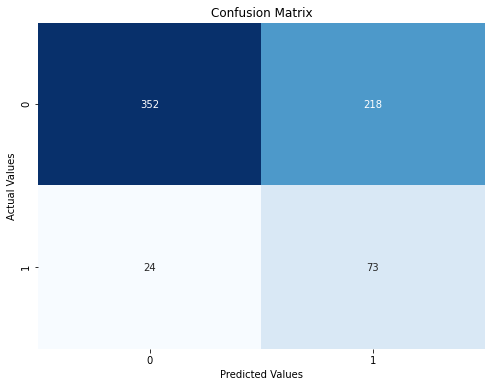

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize= (8,6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix')
plt.show()

Let's view the AUC-ROC (Area Under the Receiver Operating Characteristic Curve) Score.  This is a metric used to evaluate performance of a binary classification model.  Typically used to discriminate between the positive and negative classes across threshold values.

C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC-ROC Score (Original): 0.6810996563573882
AUC-ROC Score (Resampled): 0.6810996563573882


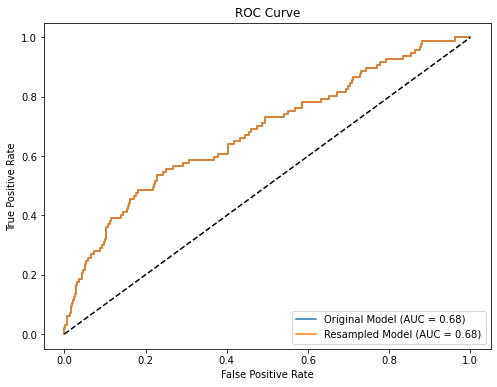

In [32]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Compute the predicted probabilities for the positive class (class 1)
y_pred_prob_original = logistic_regression_model.predict_proba(X_test_final)[:, 1]
y_pred_prob_resampled = logistic_regression_model.fit(X_train_final_resampled, y_train_resampled).predict_proba(X_test_final)[:, 1]

# Compute the AUC-ROC score
auc_original = roc_auc_score(y_test, y_pred_prob_original)
auc_resampled = roc_auc_score(y_test, y_pred_prob_resampled)

print("AUC-ROC Score (Original):", auc_original)
print("AUC-ROC Score (Resampled):", auc_resampled)

# Plot the ROC curve
fpr_original, tpr_original, _ = roc_curve(y_test, y_pred_prob_original)
fpr_resampled, tpr_resampled, _ = roc_curve(y_test, y_pred_prob_resampled)

plt.figure(figsize=(8, 6))
plt.plot(fpr_original, tpr_original, label="Original Model (AUC = {:.2f})".format(auc_original))
plt.plot(fpr_resampled, tpr_resampled, label="Resampled Model (AUC = {:.2f})".format(auc_resampled))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [33]:
# Instantiate the logistic regression model
logistic_regression_model = LogisticRegression(penalty='l1', solver='liblinear')

# Fit the model on the training data
logistic_regression_model.fit(X_train_final_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = logistic_regression_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

#Print the evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)

Accuracy: 0.7001499250374813
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.69      0.80       570
         1.0       0.29      0.76      0.43        97

    accuracy                           0.70       667
   macro avg       0.62      0.73      0.61       667
weighted avg       0.85      0.70      0.74       667



In [34]:
#clf = GridSearchCV(logistic_regression_model, parameters)
#clf.fit(iris.data, iris.target)
clf_resampled = GridSearchCV(estimator=logistic_regression_model,
             param_grid={'penalty': ['l1', 'l2', 'none', 'elasticnet'], 'C': [0.1, 0.01, 0.0001], 'solver' : ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']})
clf_resampled.fit(X_train_final_resampled, y_train_resampled)


C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\

C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\byrdw\anaconda3\envs

C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means t

C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear

C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logis

C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\byrdw\anaconda3\envs\learn

C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\byrdw\anaconda3\envs\learn-env\li

GridSearchCV(estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': [0.1, 0.01, 0.0001],
                         'penalty': ['l1', 'l2', 'none', 'elasticnet'],
                         'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag',
                                    'saga']})

In [35]:
clf_resampled.best_params_

{'C': 0.1, 'penalty': 'none', 'solver': 'newton-cg'}

In [36]:
logistic_regression_model = LogisticRegression(penalty='l2', solver='newton-cg', C = 0.8)

# Fit the model on the training data
logistic_regression_model.fit(X_train_final_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = logistic_regression_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

#Print the evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)

Accuracy: 0.7091454272863568
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.70      0.80       570
         1.0       0.31      0.78      0.44        97

    accuracy                           0.71       667
   macro avg       0.63      0.74      0.62       667
weighted avg       0.86      0.71      0.75       667



In [37]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(logistic_regression_model, X_final, y)

In [38]:
print('Cross-Validation Scores', cv_scores)
print('Mean CV Score', cv_scores.mean())

Cross-Validation Scores [0.85457271 0.85757121 0.85907046 0.86336336 0.86186186]
Mean CV Score 0.8592879236057647


In [39]:
customer_df['churn'].value_counts()

0.0    2850
1.0     483
Name: churn, dtype: int64

As we can see, the model is very innacurate.  We will need to balance this to improve our model.

In [40]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Instantiate the logistic regression model with class weights
logistic_regression_model = LogisticRegression(class_weight={0: class_weights[0], 1: class_weights[1]})

# Fit the model on the training data
logistic_regression_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logistic_regression_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
# Evaluate the model
accuracy = logistic_regression_model.score(X_test, y_test)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)

Accuracy: 0.6626686656671664
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.65      0.77       570
         1.0       0.26      0.74      0.39        97

    accuracy                           0.66       667
   macro avg       0.60      0.70      0.58       667
weighted avg       0.84      0.66      0.71       667



C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [41]:

# Define class weights
class_weights = {0: 2, 1: 5}  # Adjust the weight for class 1 as needed

# Instantiate the logistic regression model with class weights
logistic_regression_model = LogisticRegression(class_weight=class_weights)

# Fit the model on the training data
logistic_regression_model.fit(X_train_final, y_train)

# Predict on the test data
y_pred = logistic_regression_model.predict(X_test_final)

# Evaluate the model
print('accuracy', accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))


accuracy 0.6626686656671664
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90       570
         1.0       0.44      0.53      0.48        97

    accuracy                           0.84       667
   macro avg       0.68      0.71      0.69       667
weighted avg       0.85      0.84      0.84       667



**Decision Tree** 

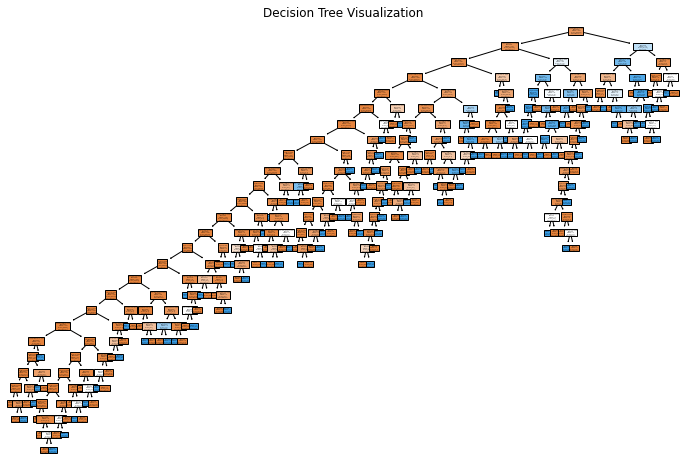

Decision Tree Model Evaluation:
Accuracy: 0.9205397301349325
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95       570
         1.0       0.72      0.74      0.73        97

    accuracy                           0.92       667
   macro avg       0.84      0.85      0.84       667
weighted avg       0.92      0.92      0.92       667



In [42]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
decision_tree_model = DecisionTreeClassifier().fit(X_train_final, y_train)

y_pred_dt = decision_tree_model.predict(X_test_final)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(decision_tree_model, filled=True, feature_names=X_final.columns, class_names=['Not Churn', 'Churn'])
plt.title("Decision Tree Visualization")
plt.show()

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
classification_rep_dt = classification_report(y_test, y_pred_dt)

print("Decision Tree Model Evaluation:")
print("Accuracy:", accuracy_dt)
print("Classification Report:")
print(classification_rep_dt)


**Pruning**

In [43]:
pruned_tree_model = DecisionTreeClassifier(ccp_alpha = 0.00001)

pruned_tree_model.fit(X_train_final, y_train)

y_pred_pruned_tree = pruned_tree_model.predict(X_test_final)

accuracy_pruned_tree = accuracy_score(y_test, y_pred_pruned_tree)
classification_rep_pruned_tree = classification_report(y_test, y_pred_pruned_tree)

print('Accuracy:', accuracy_pruned_tree)
print('Classification Report:')
print(classification_rep_pruned_tree)

Accuracy: 0.9175412293853074
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       570
         1.0       0.70      0.76      0.73        97

    accuracy                           0.92       667
   macro avg       0.83      0.85      0.84       667
weighted avg       0.92      0.92      0.92       667



In [44]:
cv_scores = cross_val_score(pruned_tree_model, X_test_final, y_test, cv=5)
print('Cross-Validation Scores', cv_scores)
print('Mean CV Score', cv_scores.mean())

Cross-Validation Scores [0.92537313 0.94029851 0.90977444 0.90977444 0.92481203]
Mean CV Score 0.9220065088093368


In [45]:
pruned_tree_model.feature_importances_

array([4.33120810e-03, 0.00000000e+00, 6.49420240e-04, 1.84749001e-04,
       1.72032508e-03, 2.56175058e-03, 8.08073472e-04, 0.00000000e+00,
       5.61402768e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.47579824e-03, 8.13732027e-03, 9.48204028e-05, 0.00000000e+00,
       0.00000000e+00, 2.63790304e-04, 0.00000000e+00, 2.53429130e-03,
       1.23033422e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.85327483e-03, 5.65645528e-04, 4.18530941e-04, 3.46970930e-03,
       0.00000000e+00, 5.39471403e-04, 4.17951784e-03, 1.04811104e-04,
       0.00000000e+00, 2.10015128e-03, 2.34146479e-03, 0.00000000e+00,
       5.09625398e-03, 0.00000000e+00, 0.00000000e+00, 1.17824346e-04,
       2.69268450e-03, 0.00000000e+00, 5.38414319e-04, 1.00925762e-04,
       2.89157597e-03, 0.00000000e+00, 4.63771136e-04, 2.92910718e-03,
       0.00000000e+00, 1.50890539e-03, 2.14288080e-02, 9.34024937e-03,
       5.80363054e-02, 6.22860596e-02, 5.03478342e-03, 6.03301099e-02,
      

In [46]:
X_final.columns

Index(['state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT',
       'state_DC', 'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA',
       'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA',
       'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO',
       'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH',
       'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK',
       'state_OR', 'state_PA', 'state_RI', 'state_SC', 'state_SD', 'state_TN',
       'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI',
       'state_WV', 'state_WY', 'account length', 'area code',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes

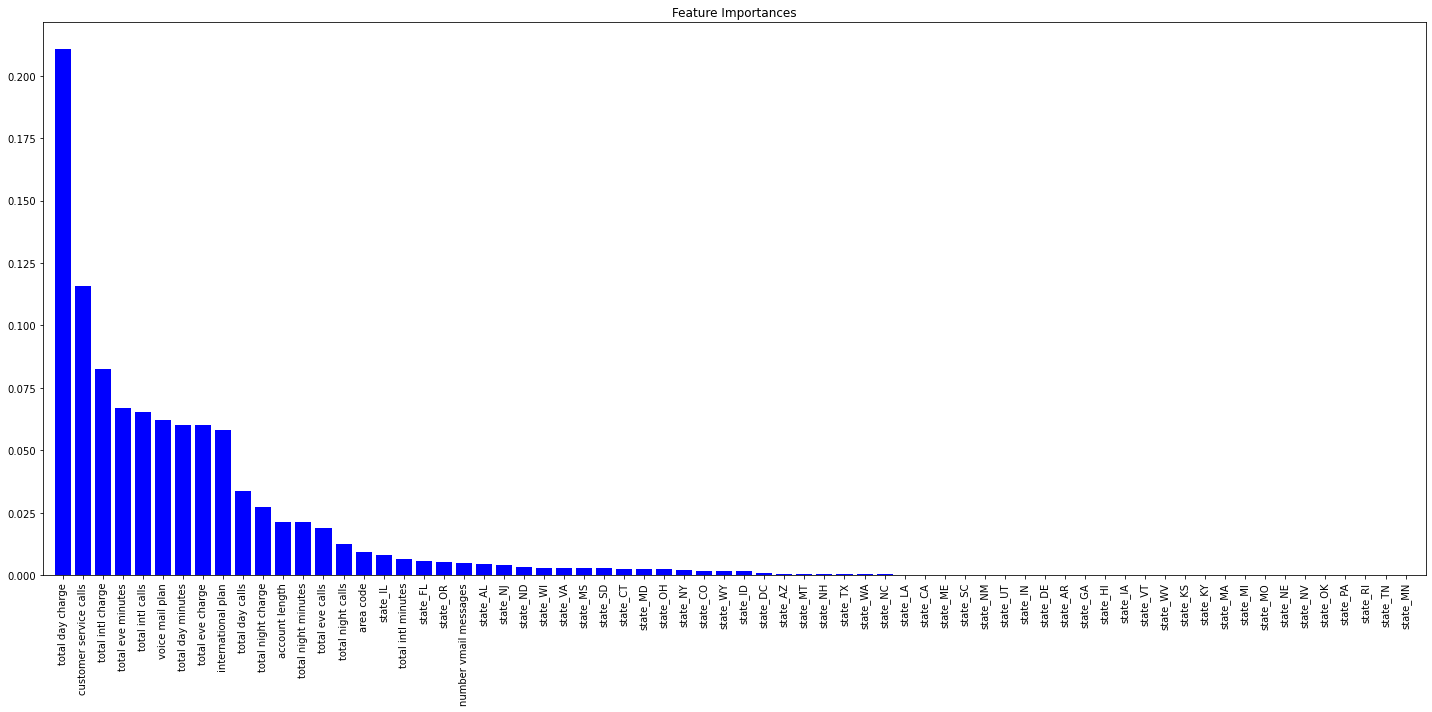

In [47]:
X_train_final_df = pd.DataFrame(X_train_final,columns=X_final.columns)

feature_importances = pruned_tree_model.feature_importances_

feature_names = X_train_final_df.columns
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(20, 10))
plt.title("Feature Importances")
plt.bar(range(X_train_final.shape[1]), feature_importances[indices], color="b", align="center")
plt.xticks(range(X_train_final.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train_final.shape[1]])
plt.tight_layout()
plt.show()

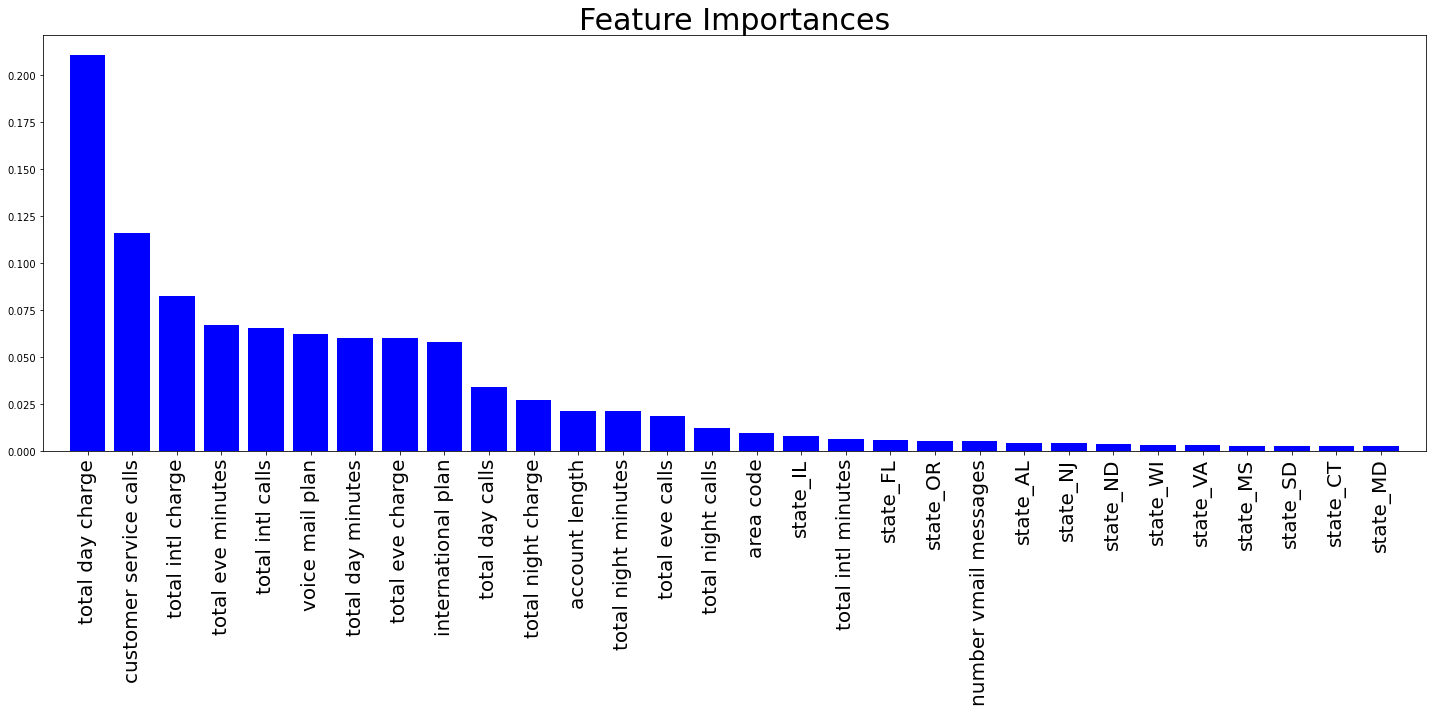

In [57]:
X_train_final_df = pd.DataFrame(X_train_final,columns=X_final.columns)

feature_importances = pruned_tree_model.feature_importances_

feature_names = X_train_final_df.columns
indices = np.argsort(feature_importances)[::-1][:30]

plt.figure(figsize=(20, 10))
plt.title("Feature Importances", fontsize=30)
plt.bar(range(30), feature_importances[indices], color="b", align="center")
plt.xticks(range(30), feature_names[indices], rotation=90, fontsize=20)
plt.xlim([-1, 30])
plt.tight_layout()
plt.show()

In [49]:
indices

array([57, 67, 66, 58, 65, 53, 55, 60, 52, 56, 63, 50, 61, 59, 62, 51, 13,
       64,  8, 36, 54,  0, 30, 27, 47, 44, 24, 40,  5, 19], dtype=int64)

In [50]:
indices[:10]

array([57, 67, 66, 58, 65, 53, 55, 60, 52, 56], dtype=int64)